# LinkedIn Salary prediction using job descriptions

# Resources:
- Original dataset: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings/
- Data scraper: https://github.com/ArshKA/LinkedIn-Job-Scraper


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Extra imports to simplify code
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Imported models
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.linear_model import LinearRegression as linr
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.ensemble import GradientBoostingClassifier as gbc

# Extra models
from sklearn.linear_model import RidgeClassifier as lnrc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge

In [ ]:
def plot_median_salary_distribution(dataframe, column='med_salary', bins=50):
    """
    Function to plot the distribution of median salaries in a bar chart.

    :param dataframe: The pandas DataFrame containing the salary data.
    :param column: The name of the column with median salary data.
    :param bins: The number of bins to use for the histogram.
    """
    # Calculate the min and max salary values
    min_salary = 0
    max_salary = dataframe[column].max()

    # Define the range as 120% of the min and max salary values
    salary_range = (min_salary, max_salary * 1.2)

    # Plot the histogram within the specified range
    dataframe[column].hist(bins=bins, range=salary_range, edgecolor='black')

    # Set the title and labels
    plt.title('Distribution of Median Salaries')
    plt.xlabel('Median Salary')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

In [ ]:
# Upload the job posting csv to colab manually from the side bar
df = pd.read_csv('./drive/MyDrive/Data/job_postings.csv', encoding='utf-8')
# Display the first few rows of the dataframe
df.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
0,85008768,NaN,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",...,1708301126000,NaN,NaN,NaN,1692749193000,NaN,1,FULL_TIME,USD,BASE_SALARY
1,133114754,77766802.0,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",...,1695426553000,NaN,NaN,NaN,1692834553000,NaN,0,FULL_TIME,NaN,NaN
2,133196985,1089558.0,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,NaN,NaN,NaN,NaN,Contract,"New York, NY",...,1695321872000,NaN,NaN,NaN,1692729872000,NaN,0,CONTRACT,NaN,NaN
3,381055942,96654609.0,Business Manager,Business ManagerFirst Baptist Church ForneyFor...,NaN,NaN,NaN,NaN,Full-time,"Forney, TX",...,1695424007000,NaN,NaN,NaN,1692832007000,NaN,0,FULL_TIME,NaN,NaN
4,529257371,1244539.0,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...,NaN,NaN,NaN,NaN,Full-time,"New York, NY",...,1708419602000,NaN,NaN,NaN,1692867714000,NaN,1,FULL_TIME,NaN,NaN


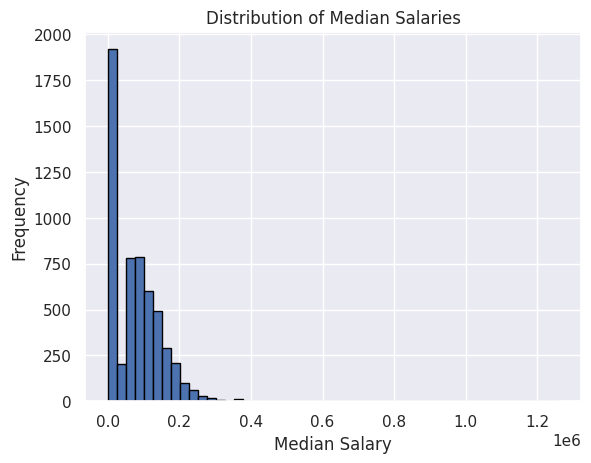

In [ ]:
def calculate_med_salary(row):
    if pd.isna(row['med_salary']):
        if None not in (row['max_salary'], row['min_salary']):
          return (row['max_salary'] + row['min_salary']) / 2
        return None
    else:
        return row['med_salary']

# Preprocessing
df.replace([np.nan], None, inplace = True)
# Calculate the average of max_salary and min_salary for rows where med_salary is NaN
df['med_salary'] = df.apply(calculate_med_salary, axis=1)
plot_median_salary_distribution(df)